#**Morphometric and Morphological Sex Identification of *Tegillarca granosa (T. granosa)* Blood Cockles**

## Simple CNN Design

## **References**


*   code: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

*   website: https://www.analyticsvidhya.com/blog/2021/06/mnist-dataset-prediction-using-keras/



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import random
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import KFold
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras import layers

# eager execution
tf.compat.v1.enable_eager_execution()

# initialize seeds
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# path to the dataset
train_data_dir = "/content/drive/My Drive/SP 2024/Combined-Augmentation/Left Lateral/"

# model configuration
batch_size = 50
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 20
verbosity = 1
num_folds = 5
metrics = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]


# per-fold score containers
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
all_predictions = []
all_true_labels = []
fold_history = []

# load the dataset using image_dataset_from_directory
dataset = image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Female', 'Male'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    interpolation='nearest',
    shuffle=True,
    seed=42,
    follow_links=False,
)


# dataset to list of images and labels
image_files = []
labels = []
for images, batch_labels in dataset.unbatch():
    image_files.append(images.numpy())
    labels.append(batch_labels.numpy())

image_files = np.array(image_files)
labels = np.array(labels)

# define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1

# eager execution enabled on GPU
with tf.device('/device:GPU:0'):
    for train, test in kfold.split(image_files, labels):
        # gather data for the current fold
        train_images = image_files[train]
        train_labels = labels[train]
        val_images = image_files[test]
        val_labels = labels[test]

        # create train and validation datasets
        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

        # CNN model
        model = Sequential([
            layers.Rescaling(1./255, input_shape=(256, 256, 3)),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((5, 5), padding='same'),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D((5, 5), padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        # new optimizer for each fold
        optimizer = Adam(learning_rate=0.001)

        # compile the model with a new optimizer for each fold
        model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

        # training for the current fold
        print(f'------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        try:
            # fit the model to the current fold
            history = model.fit(train_ds, epochs=no_epochs, validation_data=val_ds, verbose=verbosity)
        except Exception as e:
            print(f"Error during training: {e}")
            continue

        # model evaluation
        scores = model.evaluate(val_ds, verbose=0)
        # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
        print(f'Score for fold {fold_no}:')
        for metric, score in zip(model.metrics_names, scores):
            print(f'{i}: {score}')


        # append the scores
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        all_predictions.append(scores[2])
        all_true_labels.append(scores[3])

        precision = scores[2]
        recall = scores[3]

        precision_per_fold.append(precision)
        recall_per_fold.append(recall)

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_per_fold.append(f1)


        # predictions on the validation set
        predictions = model.predict(val_ds)
        binary_predictions = (predictions > 0.5).astype(int)



        # increment fold number
        fold_no += 1

# average scores
print('------------------------------------------------------------------------')
print('Score per fold:')
for i in range(len(acc_per_fold)):
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print(f'> F1 score: {np.mean(f1_per_fold)}')
print('------------------------------------------------------------------------')

model.summary()

**Separated into Functions**

*   seed and environment
*   load dataset
*   cnn model
*   train model
*   evaluate model [metrics]
*   train and evaluate kfolds
*   display result
*   visualizations











## version 2

In [63]:
import tensorflow as tf
import random
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import KFold

tf.config.run_functions_eagerly(True)
tf.compat.v1.enable_eager_execution()
train_data_dir = "/content/drive/My Drive/FOURTH YEAR/SP/SP 2024/Angles/Colored/Left_Lateral_Colored/"
# train_data_dir = "/content/drive/My Drive/SP 2024/Combined-Augmentation/Left Lateral/"

def seed_and_environment():
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_random_seed(42)

def load_dataset(train_data_dir, batch_size, img_width, img_height):
    dataset = image_dataset_from_directory(
        train_data_dir,
        labels='inferred',
        label_mode='int',
        class_names=['Female', 'Male'],
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        shuffle=True,
        seed=42,
        )

    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels).astype(np.float32)

def cnn_model(img_width=256, img_height=256):
    model = Sequential([
        layers.Input(shape=(img_width, img_height,3)),
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((5, 5), padding='same'),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((5, 5), padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def train_evaluate_fold(
    train_data_dir,
    batch_size=50,
    img_width=256,
    img_height=256,
    no_epochs=2,
    num_folds=2
):
    seed_and_environment()
    image_files, labels = load_dataset(train_data_dir, batch_size, img_width, img_height)
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    all_predictions = []
    all_true_labels = []
    acc_per_fold = []
    loss_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []
    auc_per_fold = []
    fold_history = []
    fold_metrics = {
        'fold_no': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'auc':[]
    }

    for fold_no, (train_idx, test_idx) in enumerate(kfold.split(image_files, labels), 1):
        print(f'\n{"-"*80}')
        print(f'Training fold {fold_no}')

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[train_idx], labels[train_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(
            (image_files[test_idx], labels[test_idx])
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and compile model
        model = cnn_model(img_width, img_height)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=binary_crossentropy,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        # Train
        history = model.fit(
            train_ds,
            epochs=no_epochs,
            validation_data=val_ds,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

        )
        fold_history.append(history)

        # Evaluate
        scores = model.evaluate(val_ds, verbose=0)
        print(f'\nFold {fold_no} Scores:')
        for name, score in zip(model.metrics_names, scores):
            print(f"{name}: {score:.4f}")

        y_pred = model.predict(val_ds)
        y_true = labels[test_idx]
        fpr, tpr,_ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision = scores[2]
        recall = scores[3]
        f1 = (2 * (scores[2] * scores[3]) / (scores[2] + scores[3] + 1e-7))


        # Store metrics
        fold_metrics['fold_no'].append(fold_no)
        fold_metrics['loss'].append(scores[0])
        fold_metrics['accuracy'].append(scores[1] * 100)
        fold_metrics['precision'].append(precision)
        fold_metrics['recall'].append(recall)
        fold_metrics['f1_score'].append(f1)
        fold_metrics['auc'].append(roc_auc)

        # Append scores
        all_predictions.append(y_pred)
        all_true_labels.append(y_true)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        auc_per_fold.append(roc_auc)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)


    # Display results
    print('\n' + '-'*80)
    print('Score per fold:')
    for i in range(len(acc_per_fold)):
      print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
      print(f'> Fold {i + 1} - Precision: {precision_per_fold[i]}%')
      print(f'> Fold {i + 1} - Recall: {recall_per_fold[i]}%')
      print(f'> Fold {i + 1} - F1 score: {f1_per_fold[i]}%')
      print(f'> Fold {i + 1} - AUC: {auc_per_fold[i]}%')

    print('\n' + '-'*80)
    print('Average Scores for all folds:')
    print(f'Accuracy: {np.mean(acc_per_fold):.2f}% (±{np.std(acc_per_fold):.2f})')
    print(f'Loss: {np.mean(loss_per_fold):.4f} (±{np.std(loss_per_fold):.4f})')
    print(f'Precision: {np.mean(precision_per_fold):.4f} (±{np.std(precision_per_fold):.4f})')
    print(f'Recall: {np.mean(recall_per_fold):.4f} (±{np.std(recall_per_fold):.4f})')
    print(f'F1: {np.mean(f1_per_fold):.4f} (±{np.std(f1_per_fold):.4f})')
    print('-'*80 + '\n')

    return model, fold_history, all_predictions, all_true_labels

# Run training
model, fold_history, all_predictions, all_true_labels = train_evaluate_fold(train_data_dir)

# Save the model
# trained_model.save('gender_classifier_model')

# model summary
model.summary()

Found 226 files belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



--------------------------------------------------------------------------------
Training fold 1
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.5324 - auc: 0.5180 - loss: 0.6986 - precision: 0.5368 - recall: 0.5245 - val_accuracy: 0.4956 - val_auc: 0.6967 - val_loss: 0.7247 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.4739 - auc: 0.4273 - loss: 0.7623 - precision: 0.4170 - recall: 0.1219 - val_accuracy: 0.4956 - val_auc: 0.7137 - val_loss: 0.6916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Fold 1 Scores:
loss: 0.6916
compile_metrics: 0.4956
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

--------------------------------------------------------------------------------
Training fold 2
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 10s/step - accuracy: 0.4412 - auc: 0.4372 - loss: 0.7761 - precision: 0.4031 - recall: 0.2718 - val_accuracy: 0.4867 - val_auc: 0.6008 - val_loss: 0.7101 - val_precision: 0.4867 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 13s/step - accuracy: 0.4847 - auc: 0.5111 - loss: 0.7103 - precision: 0.4891 - recall: 0.9148 - val_accuracy: 0.4867 - val_auc: 0.5658 - val_loss: 0.6937 - val_precision: 0.4867 - val_recall: 1.0000

Fold 2 Scores:
loss: 0.6937
compile_metrics: 0.4867
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step

--------------------------------------------------------------------------------
Score per fold:
> Fold 1 - Loss: 0.6916207075119019 - Accuracy: 49.55752193927765%
> Fold 1 - Precision: 0.0%
> Fold 1 - Recall: 0.0%
> Fold 1 - F1 score: 0.0%
> Fold 1 - AUC: 0.7343358395989975%
> Fold 2 - Loss: 0.6937204003334045 - Accuracy: 48.67256581783295%
> Fold 2 - Precision: 0.48672565817832947%
> Fold 2 - Recall: 1.0%
> Fold 2 - F1 score: 0.654761855

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 52, 52, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │         495,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,548,389 (5.91 MB)

 Trainable params: 516,129 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,032,260 (3.94 MB)

# **Visualizing the results**
*   Accuracy vs Epoch
*   Confusion Matrix
*   AUC
*   ROC





In [62]:
import pandas as pd

all_fold_record = []
for fold_no, history in enumerate(fold_history):
  fold_data = history.history.copy()
  fold_data["fold"] = fold_no + 1
  all_fold_record.extend(pd.DataFrame(fold_data).to_dict("records"))

history_df = pd.DataFrame(all_fold_record)
history_df.head()


,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall,fold
0,0.539823,0.533542,0.695480,0.524590,0.581818,0.495575,0.696742,0.724733,0.000000,0.0,1
1,0.477876,0.426959,0.752732,0.388889,0.127273,0.495575,0.713659,0.691621,0.000000,0.0,1
2,0.442478,0.441259,0.794567,0.406250,0.228070,0.486726,0.600784,0.710063,0.486726,1.0,2
3,0.504425,0.512218,0.705448,0.504854,0.912281,0.486726,0.565831,0.693720,0.486726,1.0,2


# **Training and Validation Accuracy across Epoch**

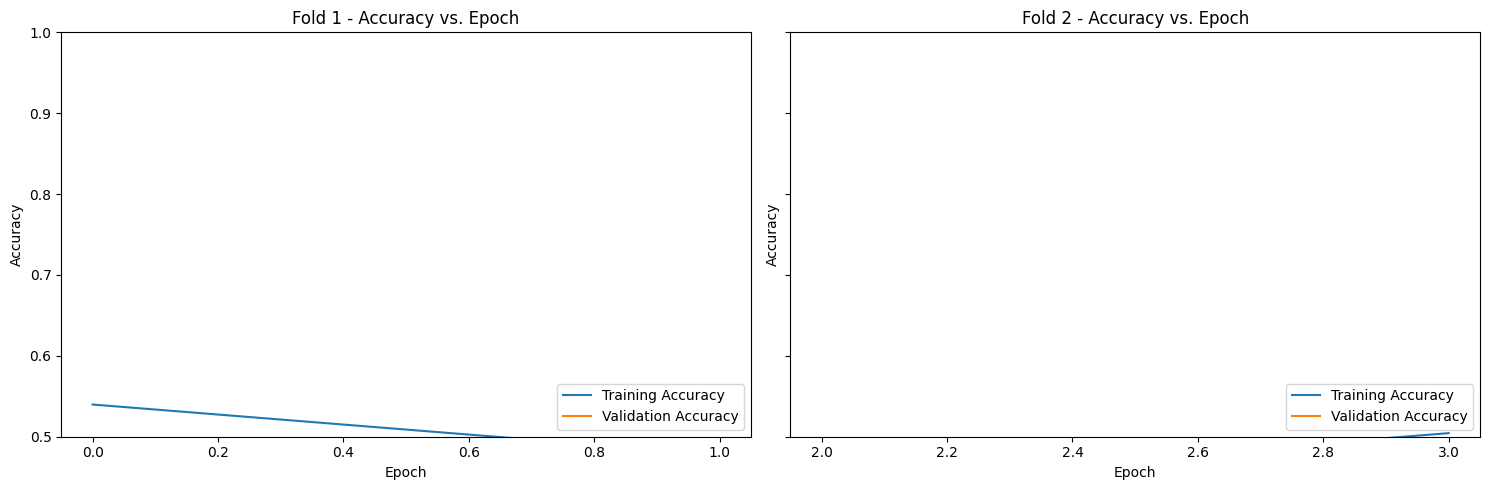

In [31]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    num_folds = history_df['fold'].nunique()
    fig, axes = plt.subplots(1, num_folds, figsize=(15, 5), sharey=True)

    for i, fold_no in enumerate(history_df['fold'].unique()):
        fold_data = history_df[history_df['fold'] == fold_no]
        axes[i].plot(fold_data['accuracy'], label='Training Accuracy')
        axes[i].plot(fold_data['val_accuracy'], label='Validation Accuracy')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_ylim([0.5, 1])
        axes[i].legend(loc='lower right')
        axes[i].set_title(f'Fold {fold_no} - Accuracy vs. Epoch')

    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **One plot for each fold**

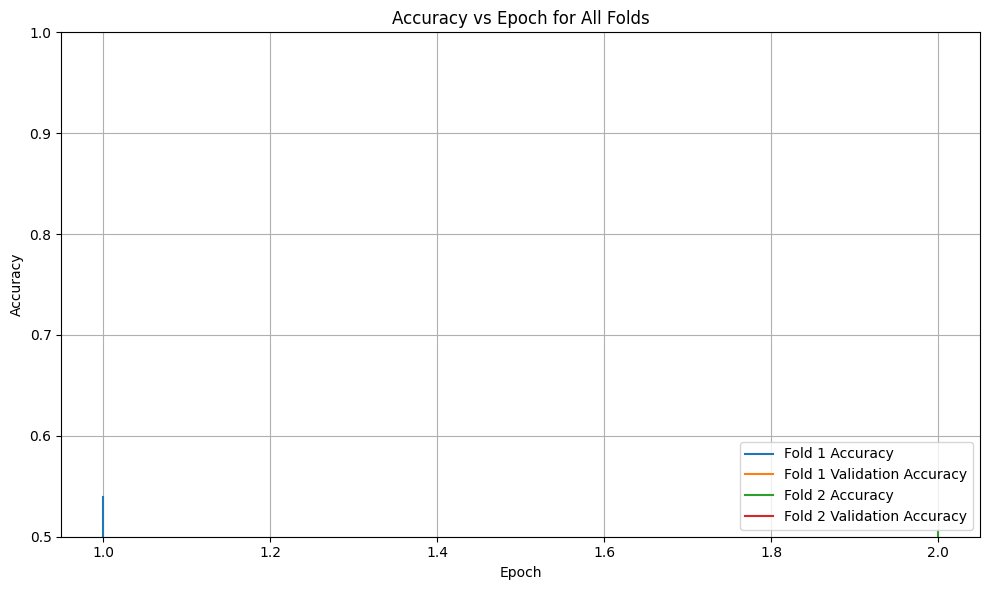

In [53]:
def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))

    for fold_no in history_df['fold'].unique():
        fold_data = history_df[history_df['fold'] == fold_no]
        plt.plot(fold_data['fold'], fold_data['accuracy'], label=f'Fold {fold_no} Accuracy')
        plt.plot(fold_data['fold'], fold_data['val_accuracy'], label=f'Fold {fold_no} Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Accuracy vs Epoch for All Folds')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Average accuracy for all folds**

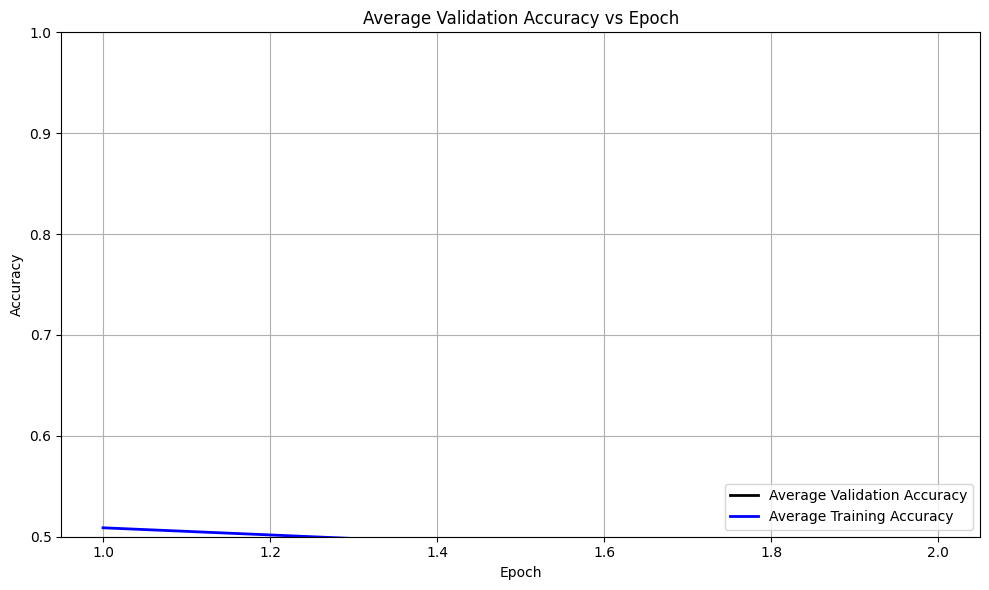

In [54]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))
    mean_val_accuracy = history_df.groupby('fold')['val_accuracy'].mean()
    mean_accuracy = history_df.groupby('fold')['accuracy'].mean()
    plt.plot(mean_val_accuracy.index, mean_val_accuracy.values, label='Average Validation Accuracy', linewidth=2, color='black')
    plt.plot(mean_accuracy.index, mean_accuracy.values, label='Average Training Accuracy', linewidth=2, color='blue')


    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Average Validation Accuracy vs Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Validation Loss Per Epoch**

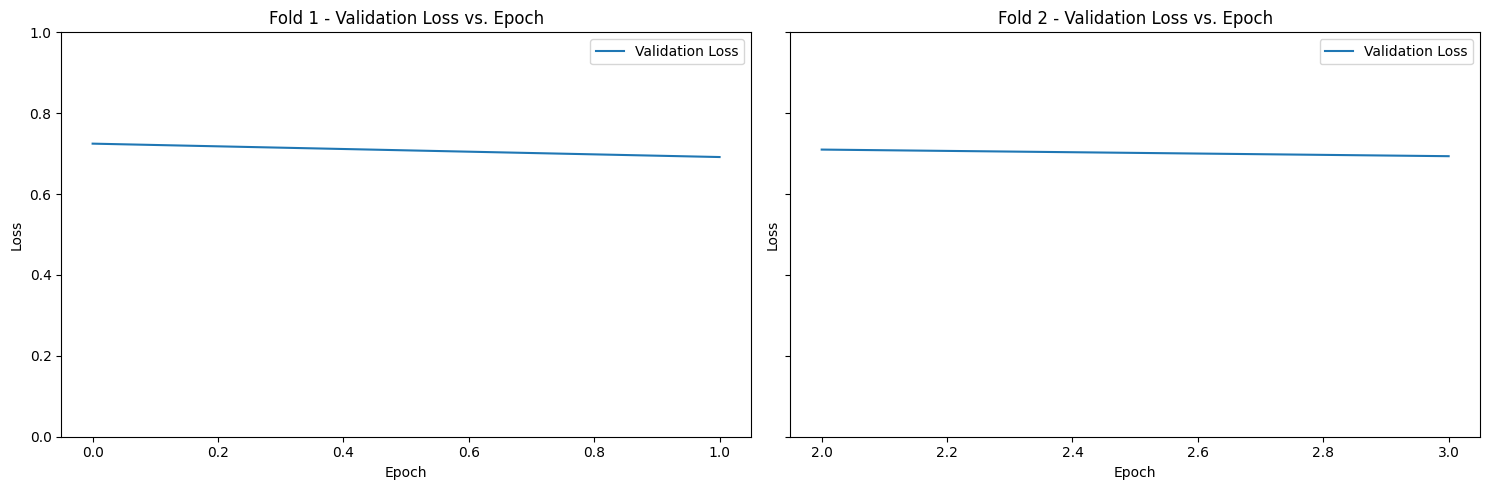

In [35]:
def validation_loss(history_df):
    num_folds = history_df['fold'].nunique()
    fig, axes = plt.subplots(1, num_folds, figsize=(15, 5), sharey=True)
    for i, fold_no in enumerate(history_df['fold'].unique()):
        fold_data = history_df[history_df['fold'] == fold_no]
        axes[i].plot(fold_data['val_loss'], label='Validation Loss')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].set_ylim([0, 1])
        axes[i].legend(loc='upper right')
        axes[i].set_title(f'Fold {fold_no} - Validation Loss vs. Epoch')

    plt.tight_layout()
    plt.show()

validation_loss(history_df)

# **One plot each fold**

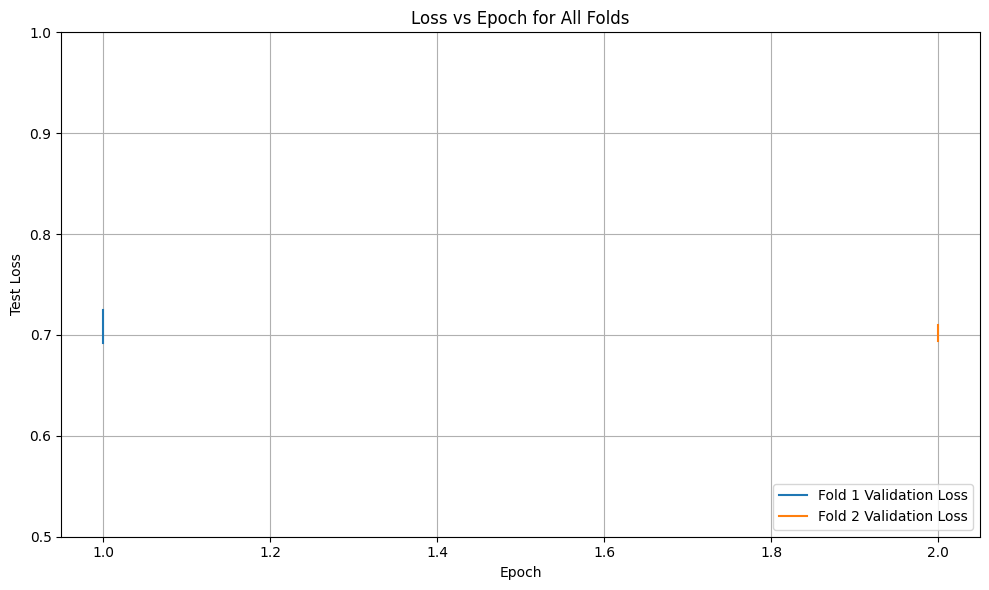

In [55]:
def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))

    for fold_no in history_df['fold'].unique():
        fold_data = history_df[history_df['fold'] == fold_no]
        plt.plot(fold_data['fold'], fold_data['val_loss'], label=f'Fold {fold_no} Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Loss vs Epoch for All Folds')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Average Loss for all Folds**

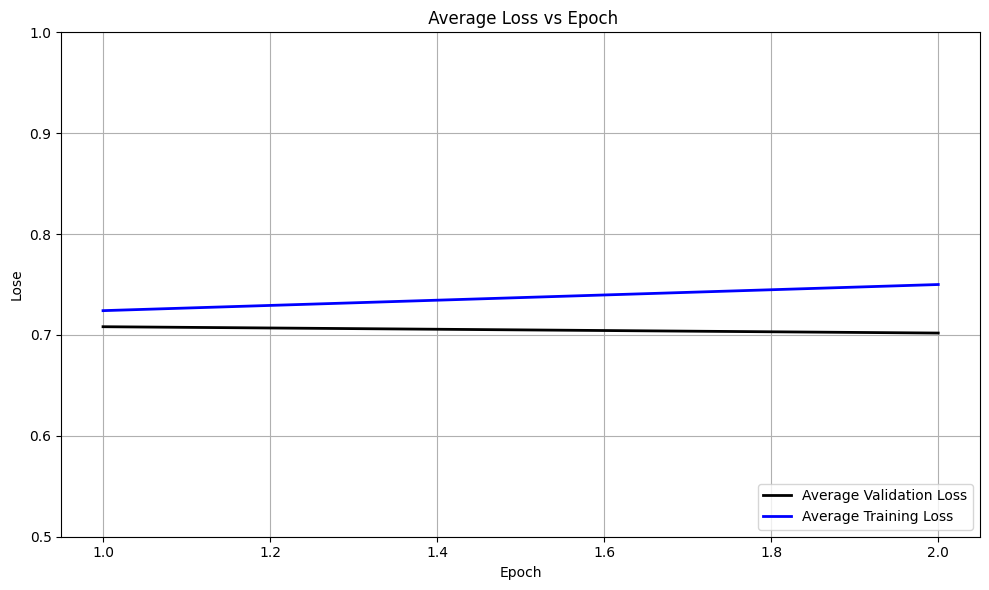

In [56]:
import matplotlib.pyplot as plt

def plot_accuracy(history_df):
    plt.figure(figsize=(10, 6))
    mean_val_accuracy = history_df.groupby('fold')['val_loss'].mean()
    mean_accuracy = history_df.groupby('fold')['loss'].mean()
    plt.plot(mean_val_accuracy.index, mean_val_accuracy.values, label='Average Validation Loss', linewidth=2, color='black')
    plt.plot(mean_accuracy.index, mean_accuracy.values, label='Average Training Loss', linewidth=2, color='blue')


    plt.xlabel('Epoch')
    plt.ylabel('Lose')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title(' Average Loss vs Epoch')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_accuracy(history_df)

# **Confusion Matrix**

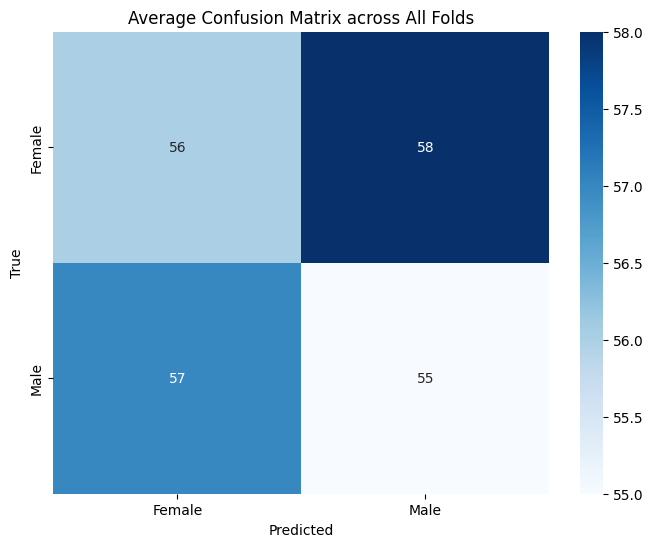

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
def plot_confusion_matrix(all_predictions, all_true_labels):
  all_predictions = np.concatenate(all_predictions)
  all_predictions = (all_predictions > 0.5).astype(int)
  all_true_labels = np.concatenate(all_true_labels)
  cm = sk_confusion_matrix(all_true_labels,all_predictions)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Average Confusion Matrix across All Folds')
  plt.show()

plot_confusion_matrix(all_predictions, all_true_labels)

# **AUC ROC Plot**

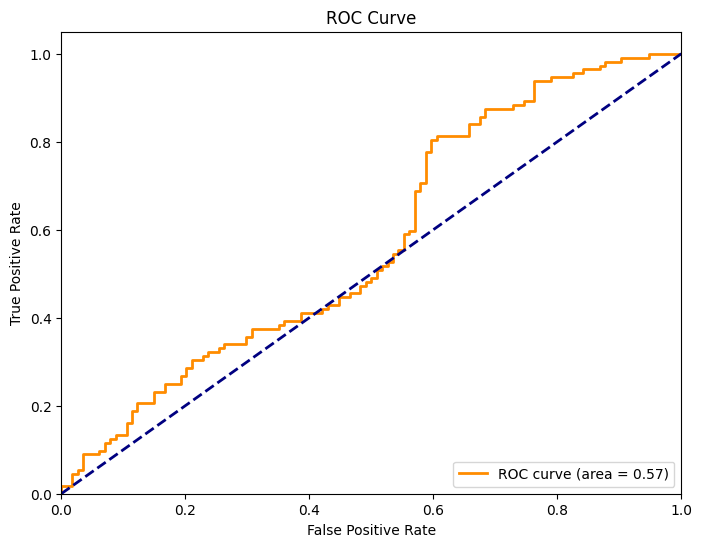

In [68]:
def auc_roc_curve(all_predictions, all_true_labels):
    all_predictions = np.concatenate(all_predictions)
    all_true_labels = np.concatenate(all_true_labels)
    fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylim([0.0, 1.05])
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

auc_roc_curve(all_predictions, all_true_labels)